# Sprawozdanie

### Projekt: Jak stworzyć **zarąbisty** mobilny skaner dokumentów w raptem 5 minut?

Patryk Guba, Maciej Dragun  
[https://pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/](https://pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/)

### Część 0: Przygotowania

In [10]:
from skimage.filters import threshold_local
from numpy import ndarray

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import imutils

%matplotlib inline

In [11]:
img1 = cv2.imread('inputs/img1.jpg', cv2.IMREAD_COLOR) 
img2 = cv2.imread('inputs/img2.jpg', cv2.IMREAD_COLOR) 
img3 = cv2.imread('inputs/img3.jpg', cv2.IMREAD_COLOR) 
img4 = cv2.imread('inputs/img4.jpg', cv2.IMREAD_COLOR) 
img_receipt = cv2.imread('inputs/paragon.jpg', cv2.IMREAD_COLOR)
img_multiple = cv2.cvtColor( cv2.imread('inputs/multiple.jpeg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
img_math = cv2.cvtColor( cv2.imread('inputs/math.jpeg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
img_shadow = cv2.cvtColor( cv2.imread('inputs/shadow.jpeg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
img_bend = cv2.cvtColor( cv2.imread('inputs/bend.jpeg', cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

test_img = img1

### Część I: Tutorial

Część poświęcona jest omówieniu kodu zawartego w przypisanym tutorialu

Autor strony kusi możliwością pobrania kodu z jego artykułów. W rzeczywistości wybranie takiej opcji przekierowuje na stronę z możliwością zakupu jego kursu dlatego konieczne jest zastosowanie strategii kopiuj-wklej. Nic nadmiernie uciążliwego jednak warte wspomnienia

Tutorial wymaga przyswojenia wcześniejszej jego części, polegającej na implementacji i omówieniu funkcji 4-punktowej transformacji perspektywicznej. Jest to jeden z elementów zakresu prac ustalonego na konsultacjach. Metoda zostanie opisana szczegółowo w dalszej części, w tej zostanie jedynie ogólnikowo. Zamieszczane komentarze są autorskie i często poruszają zagadnienia ponad zawartość tutoriala.

In [78]:
# Porządkuje listę punktów w kolejności od lewego-górnego w kierunku zgodnym z
# ruchem wskazówek zegara. 
# in:
#   pts: ndarray[tuple] - Lista punktów (x, y). Musi być czteroelementowa
# out:
#   list[tuple] - Uporządkowana lista punktów wejściowych w zadanej kolejności
# Należy pamiętać, że dla obrazów przyjmuje się, że układ współrzędnych odbity
# jest o oś OX - widać to przy wyświetlaniu obrazów wraz z osiami 
# współrzędnych. Bez tego założenia wiele z zamieszczonych komentarzy jak i 
# wynik testu w komórce nie miałaby sensu
def order_points(pts: ndarray[tuple]) -> list[tuple]:
    # zwracana wartość
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    # punkt o najmniejszej sumie współrzędnych jest górnym-lewym punktem
    rect[0] = pts[np.argmin(s)]
    # punkt o największej sumie współrzędnych jest dolnym-prawym punktem
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    # punkt o najmniejszej różnicy x - y jest górnym-prawym punktem
    rect[1] = pts[np.argmin(diff)]
    # punkt o największej różnych x - y jest dolnym-lewym punktem
    rect[3] = pts[np.argmax(diff)]
    return rect

order_points(np.array([(-1, 1), (1, 1), (-1, -1), (1, -1)]))

array([[-1., -1.],
       [ 1., -1.],
       [ 1.,  1.],
       [-1.,  1.]], dtype=float32)

In [79]:
# Zwraca obraz ograniczony 4-punktową obwiedną przetransformowany
# perskeptywicznie
# in:
#   image: ndarray - obraz
#   pts: ndarray[tuple] - obwiednia
# out:
#   ndarray - fragment obrazu ograniczony obiwiednią przetransformowany
#   perspektywicznie
def four_point_transform(image: ndarray, pts: ndarray[tuple]) -> ndarray:
    # uporządkuj punkty
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # oblicz szerokość obrazu wyjściowego, będącą maksimum z górnej i dolnej
    # krawędzi czworokątu
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # oblicz wysokość obrazu wyjściowego, będącą maksimum z lewej i prawej
    # krawędzi czworokątu
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # współrzędne punktów obrazu wyjściowego w kolejności od lewego-górnego
    # punktu w kierunku zgodnym z ruchem wskazówek zegara
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # macierz przekształcenia perspektywicznego - metoda zostanie dokładniej
    # opisana w dalszej części
    M = cv2.getPerspectiveTransform(rect, dst)
    # aplikacja macierzy transformacji
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

Przechodząc do właściwego tutorialu. Zawarty w nim kod jest raczej w formie skryptu niż pojedynczych funkcji więc zostanie on nieco przerobiony. Zawiera on dodatkowo wiele niepotrzebnych wywołań metod copy() - usunięto je

In [80]:
# celem zwiększenia prędkości kodu pewne operacje przeprowadzane będą na przeskalowanym obrazie
RATIO = 500

In [81]:
# Zwraca obraz z wykrytymi krawędziami
# in:
#   image: ndarray - obraz
# out:
#   ndarray - obraz wyjściowy z wykrytymi krawędziami
def detect_edge(image: ndarray) -> ndarray:
    # transformacja do czarnobieli + blur celem lepszego wykrycia krawędzi
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    # detekcja krawędzy Canny
    edged = cv2.Canny(gray, 75, 200) 
    return edged

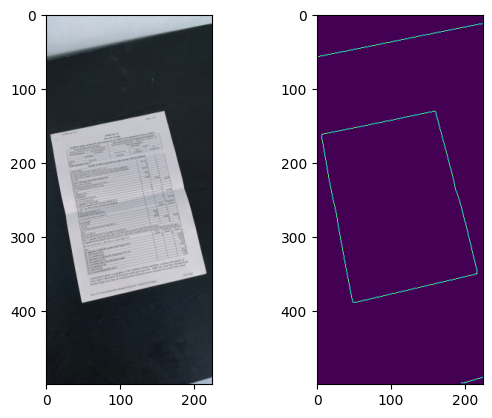

In [82]:
img_resized = imutils.resize(test_img, height = RATIO)
edged = detect_edge(img_resized)
_, ax = plt.subplots(1,2)
ax[0].imshow(img_resized)
ax[1].imshow(edged)

In [83]:
# Znajduje kontur dokumentu. Zakładamy, że dokument będzie czworokątem o
# największej powierzchni ze wszystkich innych czworokątów
# in:
#   edged: ndarray - obraz poddany detekaji krawędzi
# out:
#   ndarray[tuple] - kontur, tablica wartości (x, y)
def find_countour(edged: ndarray) -> ndarray[tuple]:
    # Znajduje wszystkie kontury. Drugi argument określa zwrócenie wszystkich 
    # konturów. Alternatywnie dla zwiększenia efektywności algorytmu kosztem
    # "wywalenia się" na pewnych przypadkach można zastosować pozostałe flagi
    # np. cv2.RETR_EXTERNAL - wtedy zwrócone zostałyby wyłącznie zewnętrzne
    # kontury co działałoby tak długo jak skanowany dokument nie znalazł się w
    # innej figurze co powinno mieć miejsce dosyć często. Pozostałe flagi (
    # cv2.RETR_CCOMP i cv2.RETR_TREE) również związane są z "zewnętrznością"
    # konturów, ale wymagałyby znacznych modyfikacji dalszego kodu. Trzeci 
    # argument określa wykorzystany algorytm. cv2.CHAIN_APPROX_SIMPLE jest
    # tym najbardziej szczegółowym
    cnts = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    # cnts jest typu tuple. W pewnych wersjach cv2 kontury są pierwszym 
    # argumentem a w innych drugim. Metoda wyłuskuje kontury niezależnie od
    # wersji
    cnts = imutils.grab_contours(cnts)
    # Sortuje kontury od największego powierzchnią do najmniejszego. Artykuł
    # z nieznanych mi przyczyn następnie bierze 5 pierwszych wyników - to w 
    # żaden sposób nie wpływa na efektywność algorytmu... 
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)
    for c in cnts:
        # długość konturu, przydatna niżej
        peri = cv2.arcLength(c, closed=True)
        # Przybliż kontur. Drugi argument to dokładność, która jest 
        # wprostproporcjonalna do długości konturu 
        approx = cv2.approxPolyDP(c, 0.02 * peri, closed=True)
        # jeśli kształt w przybliżeniu jest czworokątem
        if len(approx) == 4:
            return approx
    raise Exception("Couldn't find contour")

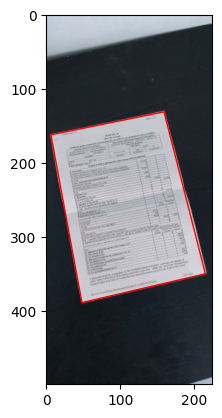

In [84]:
contour = find_countour(edged)
contour = contour.reshape(4, 2)
_, ax = plt.subplots()
ax.imshow(img_resized)
ax.add_patch(mpatches.Polygon(contour, closed=True, fill=False, ec="red"))

In [85]:
# Bierze skan z obrazu dla zadanej obwiedni
# in:
#   orig: ndarray - obraz
#   screenCnt: ndarray[tuple] - przeskalowana obwiednia 
# out:
#   ndarray[int] - obraz będący skanem
def get_scan_from_contour(orig: ndarray, screenCnt: ndarray[tuple]) -> ndarray[int]:
    # fragment obrazu zadany konturem i przetransformowany perspektywicznie
    warped = four_point_transform(orig, screenCnt)
    # do skali szarości
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    # thresholding (wygląda bardziej jak skan)
    # drugi argument to rozmiar bloku dla którego obliczane są wartości thresholdu
    # offset - stała odejmowana od średniej ważonej liczonej w bloku
    # method - metoda wyznaczania thresholdu w bloku
    T = threshold_local(warped, 11, offset = 10, method = "gaussian")
    # obraz binarny
    warped = (warped > T).astype("uint8") * 255    
    return warped

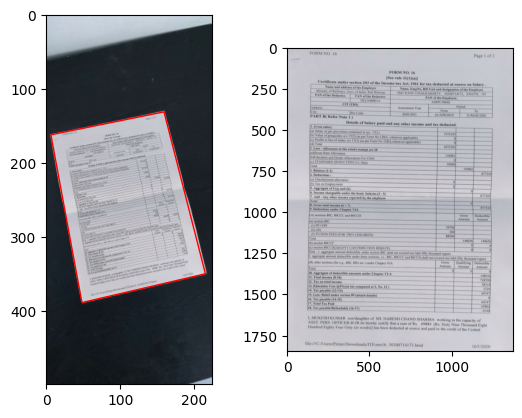

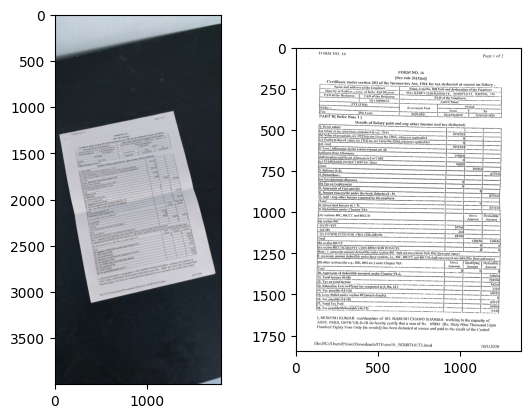

In [86]:
warped = four_point_transform(test_img, contour * (test_img.shape[0] / float(RATIO)))
_, ax = plt.subplots(1, 2)
ax[0].imshow(img_resized)
ax[0].add_patch(mpatches.Polygon(contour, closed=True, fill=False, ec="red"))
ax[1].imshow(warped)
plt.show()

scan = get_scan_from_contour(test_img, contour * (test_img.shape[0] / float(RATIO)))
_, ax = plt.subplots(1, 2)
ax[0].imshow(test_img)
ax[1].imshow(scan, cmap='binary_r')
plt.show()

Spinając całość razem

In [87]:
def get_scan(img: ndarray) -> ndarray[int]:
    img_resized = imutils.resize(img, height = RATIO)    
    edged = detect_edge(img_resized)
    contour = find_countour(edged)
    contour = contour.reshape(4, 2) * (img.shape[0] / float(RATIO)) 
    scan = get_scan_from_contour(img, contour)
    return scan

In [74]:
def show_scan(img: ndarray) -> None:
    scan = get_scan(img)
    _, ax = plt.subplots(1, 2)
    ax[0].imshow(img)
    ax[1].imshow(scan, cmap='binary_r')
    plt.show() 

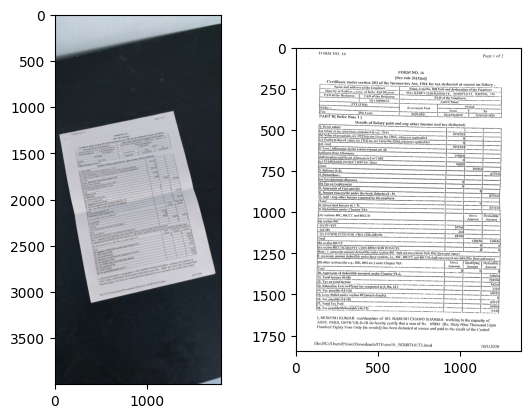

In [75]:
show_scan(test_img)

Test na innych obrazkach

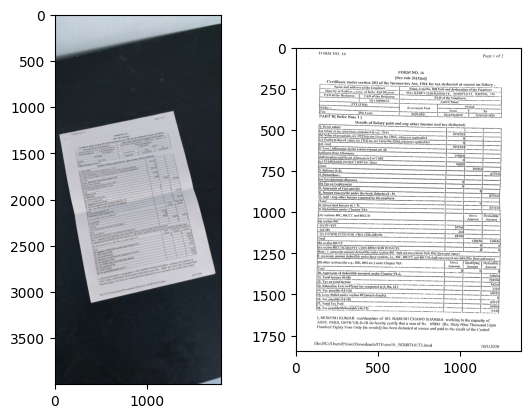

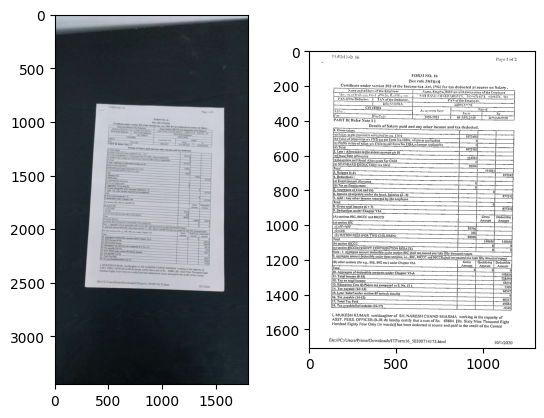

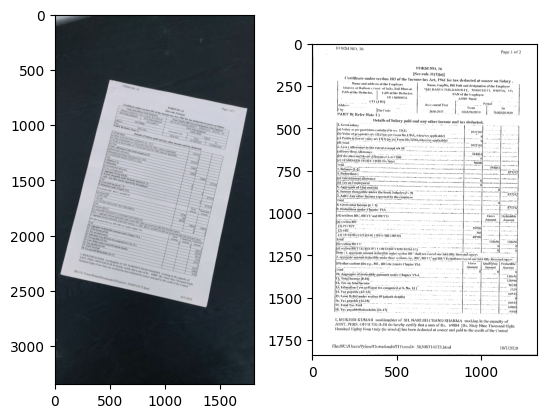

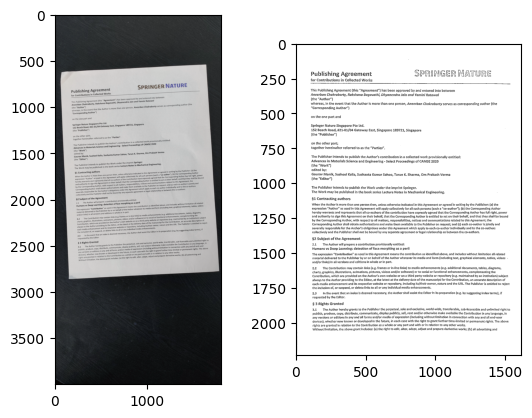

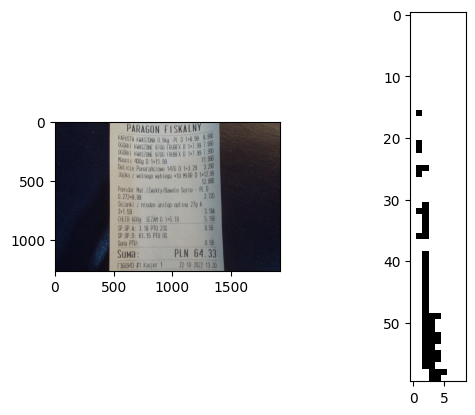

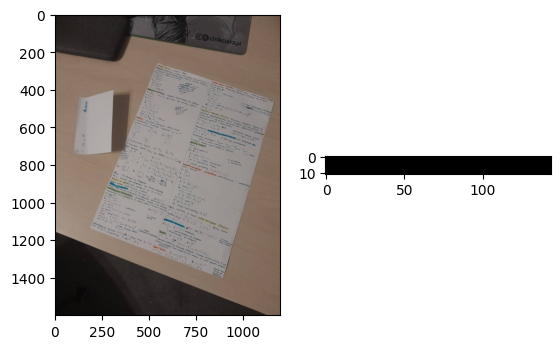

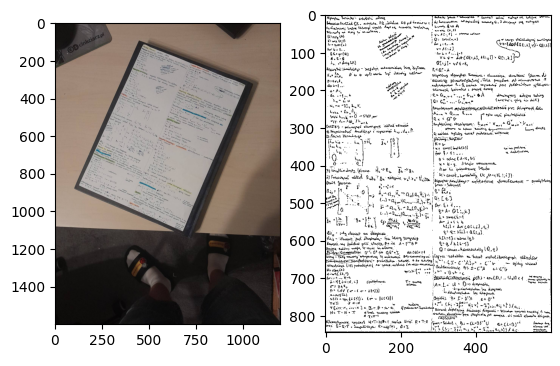

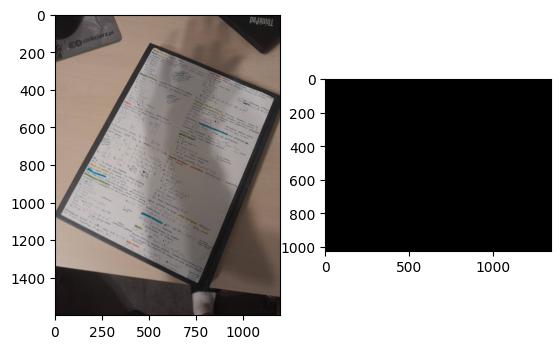

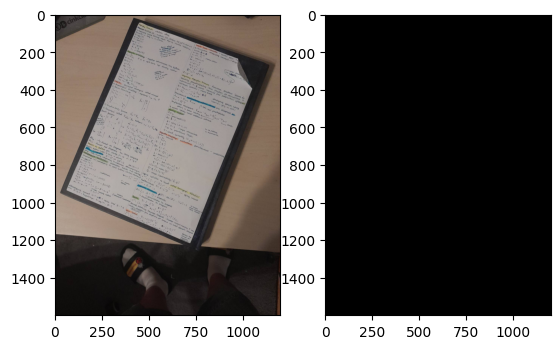

In [104]:
show_scan(img1)
show_scan(img2)
show_scan(img3)
show_scan(img4)
show_scan(img_receipt)
show_scan(img_multiple)
show_scan(img_math)
show_scan(img_shadow)
show_scan(img_bend)

### Część II: Krytyka tutoriala 

Jest kilka istotnych kwestii wartych wytknięcia omawianemu tutorialowi:
* Tutorial błędnie twierdzi, że kod jest dostępny do pobrania. Aby to uczynić należy zapłacić za kurs (czego oczywiście nie zrobiliśmy)
* Tutorial w swoim tytule określa skaner mianem "mobilnego". Raczej nie jest to prawdą. Nie żeby było to istotne z punktu widzenia przedmiotu, ale...
* Kod działa dla większości przypadków, jednak nie dla każdego (paragon.jpg)
* Założenie, że obwiednia dokumentu będzie czworokątem jest dobrą heurystyką, która czasem jednak zawodzi (bend.jpeg - obraz z zagietym rogiem)
* Wykorzystywane algorytmy są parametryzowane - jest to zrozumiałe choć stawia wyzwanie odpowiedniego dobrania parametrów. Parametry obrane w tutorialu są dobre, ale potrafią zawieść w pewnych przypadkach (multiple.jpeg - tło jest za jasne aby kod poprawnie wczytał skan, shadow.jpeg - rzucony cień psuje skan)

### Część III: Część teoretyczna

#### **Homograficzna transformacja perspektywy (four_point_transform):**

Ogólnie rzecz biorąc homografia jest takim przekształceniem, które nie zachowuje równoległości, długości i kątów, ale zachowuje kolinearność i incydentność (proste zostają proste i żaden punkt nie "zmienia" prostej).

W bardziej praktycznym i informatycznym ujęciu transformacja homograficzna wyraża transformację dwuwymiarowych punktów jednego rzutu perspektywicznego danej płaszczyzny w dwuwymiarowe punkty innego rzutu perspektywicznego tej samej płaszczyzny. Innymi słowy transformacja homograficzna określa w jaki sposób przekształcić punkty na scenie jeśli zmienimy położenie kamery - istotne jest założenie, że pierwotny trójwymiarowy obiekt znajduje się na płaszczyźnie.

Homografia to więc przekształcenie 
\begin{equation}
\begin{pmatrix}
  x'  \\
  y'  \\
  1  
\end{pmatrix} =
H
\begin{pmatrix}
  x  \\
  y  \\
  1  
\end{pmatrix}
\end{equation}
gdzie H jest macierzą 3x3

Dwuwymiarowe punkty określane są jako trójelementowe wektory gdzie z = 1. Tego typu sposób określania dwuwymiarowej przestrzeni nazywa się jednorodnością współrzędnych. Ma ona szerokie zastosowanie w grafice komputerowej ze względu na prostotę wielu wyprowadzeń przy ich zastosowaniu (wiele operacji daje się wyrażać przez operacje macierzowe).

Wzór przekształcenia homograficznego wynika ze sprytnej sztuczki zastosowanej na wzorze projekcji perspektywicznej. Rzut trójwymiarowych punktów na dwuwymiarową powierzchnię (scenę) wyraża się następująco:

\begin{equation}
\begin{pmatrix}
  x'  \\
  y'  \\
  w'  
\end{pmatrix} =
\begin{pmatrix}
  C_{1, 1} & C_{1, 2} & C_{1, 3} & C_{1, 4} \\ 
  C_{2, 1} & C_{2, 2} & C_{2, 3} & C_{2, 4} \\ 
  C_{3, 1} & C_{3, 2} & C_{3, 3} & C_{3, 4} 
\end{pmatrix}
\begin{pmatrix}
  X  \\
  Y  \\
  Z  \\
  1
\end{pmatrix}
\end{equation}

Ponieważ w przekształceniach homograficznych obiektem w trójwymiarze jest płaszczyzna możemy przyjąć, że początek układu współrzędnych znajduje się na tej płaszczyźnie tj. Z = 0. Wtedy łatwo zauważyć, że równanie upraszcza się do 

\begin{equation}
\begin{pmatrix}
  x'  \\
  y'  \\
  w'  
\end{pmatrix} =
\begin{pmatrix}
  C_{1, 1} & C_{1, 2} & C_{1, 4} \\ 
  C_{2, 1} & C_{2, 2} & C_{2, 4} \\ 
  C_{3, 1} & C_{3, 2} & C_{3, 4} 
\end{pmatrix}
\begin{pmatrix}
  X  \\
  Y  \\
  1
\end{pmatrix}
\end{equation}

Homografia ma jednakowoż odnosić jeden rzut do drugiego. Zauważmy jednak, że

\begin{equation}
\begin{pmatrix}
  x  \\
  y  \\
  1  
\end{pmatrix} =
H_{1}
\begin{pmatrix}
  X  \\
  Y  \\
  1  
\end{pmatrix}
\end{equation}

\begin{equation}
H_{1}^{-1}
\begin{pmatrix}
  x  \\
  y  \\
  1  
\end{pmatrix} =
\begin{pmatrix}
  X  \\
  Y  \\
  1  
\end{pmatrix}
\end{equation}

\begin{equation}
\begin{pmatrix}
  x'  \\
  y'  \\
  1  
\end{pmatrix} =
H_{2}
\begin{pmatrix}
  X  \\
  Y  \\
  1  
\end{pmatrix}
\end{equation}

\begin{equation}
\begin{pmatrix}
  x'  \\
  y'  \\
  1  
\end{pmatrix} =
H_{2}
H_{1}^{-1}
\begin{pmatrix}
  x  \\
  y  \\
  1  
\end{pmatrix}
\end{equation}

\begin{equation}
\begin{pmatrix}
  x'  \\
  y'  \\
  1  
\end{pmatrix} =
H
\begin{pmatrix}
  x  \\
  y  \\
  1  
\end{pmatrix}
\end{equation}

Oto wyprowadzony wzór na transformację homograficzną. Oznacza to, że istnieje 9 elementowa macierz pozwalająca odnieść jeden rzut do drugiego tak długo jak rzutowany obiekt znajduje się na płaszczyźnie

Zastosowania homografii:
* Estymacja pozycji kamery - Określenie pozycji kamery na podstawie położenia obiektu zawartego w jednej płaszczyźnie i rzutu jego 4 dowolnych punktów na scenę. Z tych danych można obliczyć macierz przekształcenia homograficznego (układ równań) której dekompozycja pozwala określić pozycję kamery 
* Transformacja perspektywy - Jeżeli wycinek obrazu znajduje się na jednej płaszczyźnie w trójwymiarze to można obliczyć jego rzut po zmianie położenia kamery na podstawie 4 punktów jego rzutu pierwotnego i odpowiadających punktów pożądanego rzutu (można je uzyskać zakładając je a priori lub na podstawie rzutu perspektywicznego dla nowego położenia kamery) 
* Sklejanie panoramy - mając dwa rzuty perspektywiczne i wiedzę o tym które punkty mogą odpowiadać tym samym obiektom w trójwymiarze (wykrywanie takich punktów to osobny problem) możemy skleić obydwa zdjęcia w jedną panoramę bez konieczności odnoszenia się do pozycji tych obiektów w trójwymiarze. Metoda wymaga założenia, że kamera pozostała w miejscu i jedynie obracała się

W tym podrozdziale zostanie omówione zagadnienie transformacji perspektywy

Tak jak zostało to wspomniane w zastosowaniach - właściwie nie potrzebujemy odnosić się do trójwymiaru. Jeżeli znamy rzut jaki chcemy uzyskać możemy przetransformować perspektywę. W przypadku użycia poniższego sprawozdania mowa o skanie gdzie kamera znajduje się bezpośrednio nad obiektem. Mając więc rogi czworokąta wiemy, że ich rzutem będzie prostokątem. Warto jednak zaznaczyć, że dla tej metody obrać można dowolne 4 punkty pierwotnego rzutu - rogi jednakowoż są szczególnie wygodne dla pożądanej w projekcie perspektywy (znowuż, ponieważ znamy ich położenie na pożądanej scenie).

Ponieważ pożądana transformacja jest transformacją homograficzną można rozpatrywane punkty zwyczajnie wstawić do wzoru na przekształcenie i rozwiązać układ równań

\begin{equation}
\begin{pmatrix}
  x'  \\
  y'  \\
  1  
\end{pmatrix} =
\begin{pmatrix}
  h_{1, 1} & h_{1, 2} & h_{1, 3} \\ 
  h_{2, 1} & h_{2, 2} & h_{2, 3} \\ 
  h_{3, 1} & h_{3, 2} & h_{3, 3} 
\end{pmatrix}
\begin{pmatrix}
  x  \\
  y  \\
  1  
\end{pmatrix}
\end{equation}

Właściwie można całość podzielić przez h$_{3, 3}$ i na nowo oznaczyć każdy z elementów analogicznie. Wtedy jedna z niewiadomych wyniesie 1 i zostanie ich 8 dzięki czemu faktycznie będzie dało się to rozwiązać przy 4 punktach

\begin{equation}
\begin{pmatrix}
  x'  \\
  y'  \\
  1  
\end{pmatrix} =
\begin{pmatrix}
  h_{1, 1} & h_{1, 2} & h_{1, 3} \\ 
  h_{2, 1} & h_{2, 2} & h_{2, 3} \\ 
  h_{3, 1} & h_{3, 2} & 1 
\end{pmatrix}
\begin{pmatrix}
  x  \\
  y  \\
  1  
\end{pmatrix}
\end{equation}

Takie równanie można sprowadzić do następującej postaci (sprowadzenie go z tej postaci jest trochę sztuczne i wymaga pewnych sztuczek)

\begin{equation}
Ah = 0
\end{equation}
\begin{equation}
A = 
\begin{pmatrix}
  -x & -y & -1 & 0 & 0 & 0 & x'x & x'y & x' \\ 
  0 & 0 & 0 & -x & -y & -1 & y'x & y'y & y' \\ 
\end{pmatrix}
\end{equation}
\begin{equation}
h = 
\begin{pmatrix}
  h_{1} & h_{2} & h_{3} & h_{4} & h_{5} & h_{6} & h_{7} & h_{8} & 1 \\ 
\end{pmatrix}^{T}
\end{equation}

Mając więc 4 razy po 2 równania możemy wyznaczyć H

Technicznie rzecz biorąc mając więcej punktów można stworzyć nadokreślony układ równań i rozwiązać go np. metodą najmniejszych kwadratów choć raczej stosuje się inne metody np. RANSAC. Idea ta nie jest raczej wykorzystywana w tego typu przypadkach użycia, częściej się ją widzi w sklejaniu panoramy. W OpenCV do wyznaczania homografii z więcej niż 4 punktów służy metoda findHomography 

tbh nie wiem czemu jako dest points bierzemy maxima z długości boków. Intuicyjnie może i to rozumiem, to takie odkopnięcie kwadratu, ale nie mam ścisłej pewności
https://andrewkay.name/blog/post/aspect-ratio-of-a-rectangle-in-perspective/
https://www.microsoft.com/en-us/research/uploads/prod/2016/11/Digital-Signal-Processing.pdf

### Część IV: Porównanie z drugim skanerem

Ze względu na niedoskonałości odtworzonego skanera postanowiliśmy spróbować innego podejścia. W tym celu zasięgnęliśmy po drugi tutorial dostępny pod tym linkiem: https://learnopencv.com/automatic-document-scanner-using-opencv/

In [4]:
MAX_SIZE = 1080

In [42]:
def resize_to_opt(img: ndarray) -> ndarray:
    # Resize image to workable size
    max_dim = max(img.shape)
    if max_dim > MAX_SIZE:
        resize_scale = MAX_SIZE / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)
    return img

def close_img(img: ndarray) -> ndarray:
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)

def cut_background(img: ndarray) -> ndarray:
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img = img * mask2[:, :, np.newaxis]
    return img

def detect_edge(img: ndarray) -> ndarray:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
    return canny

def get_contours(canny: ndarray) -> list[ndarray[int]]:
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Również i ten tutorial z nieznanych mi przyczyn bierze wyłącznie 5 pierwszych wyników
    page = sorted(contours, key=cv2.contourArea, reverse=True)
    return page

def approximate_contour(page: list[ndarray[int]]) -> list[list[int]]:
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points.
        if len(corners) == 4:
            corners = sorted(np.concatenate(corners).tolist())
            return corners
    raise Exception("Error approximating contour") 

def order_points(pts: list[list[int]]) -> list[list[int]]:
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect.astype('int').tolist()

def find_dest(pts: list[list[int]]) -> list[list[int]]:
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
 
    return order_points(destination_corners)

def apply_homography(orig_img, corners, destination_corners) -> ndarray:
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    final = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)
    return final

In [43]:
def get_scan_2(img: ndarray) -> ndarray[int]:
    img = resize_to_opt(img)
    # Zachowaj obraz
    # Pierwotnie artykuł niepotrzebnie wywoływał metodę copy() - nie wiem czemu
    # obydwa artykuły nadużywają kopiowania 
    orig_img = img
    # Repeated Closing operation to remove text from the document.
    img = close_img(img)
    # GrabCut
    img = cut_background(img)
    canny = detect_edge(img)
    # Finding contours for the detected edges.
    page = get_contours(canny)    
 
    # Detecting Edges through Contour approximation.
    # Loop over the contours.
    if len(page) == 0:
        return orig_img
    corners = approximate_contour(page)
    # For 4 corner points being detected.
    corners = order_points(corners)
 
    destination_corners = find_dest(corners)
    
    return apply_homography(orig_img, corners, destination_corners)

In [44]:
get_scan_2(test_img)

array([[[196, 195, 204],
        [194, 193, 202],
        [198, 197, 206],
        ...,
        [203, 202, 211],
        [201, 200, 209],
        [201, 200, 209]],

       [[197, 196, 204],
        [195, 195, 202],
        [198, 197, 206],
        ...,
        [203, 202, 211],
        [203, 201, 211],
        [202, 200, 210]],

       [[197, 196, 204],
        [196, 196, 203],
        [197, 196, 205],
        ...,
        [203, 202, 211],
        [202, 201, 210],
        [202, 201, 210]],

       ...,

       [[206, 204, 209],
        [206, 204, 209],
        [205, 204, 208],
        ...,
        [208, 208, 214],
        [207, 208, 213],
        [208, 209, 213]],

       [[204, 203, 207],
        [205, 204, 208],
        [205, 204, 208],
        ...,
        [207, 207, 213],
        [207, 207, 212],
        [206, 207, 211]],

       [[204, 203, 207],
        [205, 204, 208],
        [205, 204, 208],
        ...,
        [207, 207, 213],
        [206, 206, 211],
        [206, 207, 211]]